In [ ]:
!pip install --upgrade albumentations
!nvidia-smi

Fri Jul 23 13:08:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
import torchvision
import cv2
import numpy as np
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from functools import partial
import time
from copy import deepcopy

%matplotlib inline

conv = partial(nn.Conv2d, bias=False)
bn = nn.BatchNorm2d
relu = nn.ReLU

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2, ToTensor

# torch.backends.cudnn.benchmark = True

In [ ]:
transform = transforms.Compose([transforms.ToTensor()]) # simple ToTensor for now

train_set = torchvision.datasets.CIFAR10(root='./cifar10', download=True, train=True, transform=transform)


Files already downloaded and verified


In [ ]:
train_set.data.shape # train data shape

(50000, 32, 32, 3)

In [ ]:
type(train_set.data), type(train_set.targets)

(numpy.ndarray, list)

In [ ]:
# calculate mean and standard deviation

mean = np.mean(train_set.data, axis=(0,1,2))


sdev = np.std(train_set.data, axis=(0, 1, 2))


In [ ]:
mean.shape

(3,)

In [ ]:
mean = mean/255
sdev = sdev/255

In [ ]:
SEED = 101
BATCH = 512

cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

if cuda:
    torch.cuda.manual_seed(SEED)

device = torch.device("cuda" if cuda else "cpu")

# dataloader arguments
dataloader_args = dict(shuffle=True, batch_size=BATCH, num_workers=2, pin_memory=True)\
    if cuda else dict(shuffle=True, batch_size=32)


CUDA Available? True


In [ ]:
# dataset= torchvision.datasets.CIFAR10(root='./cifar10/data/', transform=transform, train= True, download=True)
# test_set= torchvision.datasets.CIFAR10(root="./cifar10/data/", transform=transform, train= False)

# def ZCA_whitening(X):
#     X= X.reshape((-1, np.product(X.shape[1:])))
#     X_centered= X - np.mean(X, axis= 0)
#     Sigma= np.dot(X_centered.T, X_centered) / X_centered.shape[0]
#     U, Lambda, _= np.linalg.svd(Sigma)
#     W= np.dot(U, np.dot(np.diag(1.0/np.sqrt(Lambda + 1e-5)), U.T))
    
#     X_ZCA= np.dot(X_centered, W.T)
#     X_ZCA_rescaled = (X_ZCA - X_ZCA.min()) / (X_ZCA.max() - X_ZCA.min())
#     return X_ZCA_rescaled


In [ ]:
# # ref: https://discuss.pytorch.org/t/how-to-apply-the-zca-whitening-matrix-correctly-with-lineartransformation/19168
# def computeZCAMAtrix():
#     root = 'cifar10/' 
#     temp= torchvision.datasets.CIFAR10(root = root,
#                                   train = True,
#                                   download = True)
        
#     #normalize the data to [0 1] range
#     temp.data=temp.data/255
    
#     #compute mean and std and normalize the data to -1 1 range with 1 std
#     mean=temp.data.mean(axis=(0,1,2))
#     std=temp.data.std(axis=(0,1,2))   
#     temp.data=np.multiply(1/std,np.add(temp.data,-mean)) 
    
    
#     #reshape data from M x C x W x H to M x N where N=C x W x H 
#     X = temp.data
#     X = X.reshape(-1, 3072)
    
#     # compute the covariance 
#     cov = np.cov(X, rowvar=False)   # cov is (N, N)
    
#     # singular value decomposition
#     U,S,V = np.linalg.svd(cov)     # U is (N, N), S is (N,1) V is (N,N)
#     # build the ZCA matrix which is (N,N)
#     epsilon = 1e-5
#     zca_matrix = np.dot(U, np.dot(np.diag(1.0/np.sqrt(S + epsilon)), U.T))
#     return (torch.from_numpy(zca_matrix).float(), torch.from_numpy(mean), std)  


# # taken from : https://github.com/semi-supervised-paper/semi-supervised-paper-implementation/blob/e39b61ccab/semi_supervised/core/utils/data_util.py#L150
# class ZCATransformation(object):
#     def __init__(self, transformation_matrix, transformation_mean):
#         if transformation_matrix.size(0) != transformation_matrix.size(1):
#             raise ValueError("transformation_matrix should be square. Got " +
#                              "[{} x {}] rectangular matrix.".format(*transformation_matrix.size()))
#         self.transformation_matrix = transformation_matrix
#         self.transformation_mean = transformation_mean

#     def __call__(self, tensor):
#         """
#         Args:
#             tensor (Tensor): Tensor image of size (N, C, H, W) to be whitened.
#         Returns:
#             Tensor: Transformed image.
#         """
#         if tensor.size(1) * tensor.size(2) * tensor.size(3) != self.transformation_matrix.size(0):
#             raise ValueError("tensor and transformation matrix have incompatible shape." +
#                              "[{} x {} x {}] != ".format(*tensor[0].size()) +
#                              "{}".format(self.transformation_matrix.size(0)))
        
#         c1_mean, c2_mean, c3_mean = self.transformation_mean
        
#         tensor[:, 0, :, :] = tensor[:, 0, :, :] - c1_mean
#         tensor[:, 1, :, :] = tensor[:, 1, :, :] - c2_mean
#         tensor[:, 2, :, :] = tensor[:, 2, :, :] - c3_mean

#         batch = tensor.size(0)

#         flat_tensor = tensor.view(batch, -1)
#         transformed_tensor = torch.mm(flat_tensor , self.transformation_matrix)

#         tensor = transformed_tensor.view(tensor.size())
#         return tensor

#     def __repr__(self):
#         format_string = self.__class__.__name__ + '('
#         format_string += (str(self.transformation_matrix.numpy().tolist()) + ')')
#         return format_string

In [ ]:
# dataset_zca= ZCA_whitening(dataset.data)
# test_set_zca= ZCA_whitening(test_set.data)

# dataset_zca= torch.tensor(dataset_zca.reshape(-1,3, 32,32))
# test_set_zca= torch.tensor(test_set_zca.reshape(-1,3, 32,32))

In [ ]:
# class GaussNoise():
#     def __init__(self, mean , sdev):
#         self.mean = mean
#         self.sdev = sdev
    
#     def __call__(self, tensor=None, size=None):
#         if tensor:
#             val= torch.rand(tensor.size(), dtype=tensor.dtype) * self.sdev + self.mean

#             return val
#         else:
#             return np.random.rand(size) * self.sdev + self.mean

In [ ]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.smoothing = smoothing
    def forward(self, x, target):
        confidence = 1. - self.smoothing
        logprobs = F.log_softmax(x, dim=-1)
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()

In [ ]:
# noise = GaussNoise(mean=mean, sdev=sdev)
# noise_to_add = noise(size=mean.shape[0])
# noise(size=1)[0], noise_to_add

In [ ]:
# taken from : https://github.com/jackryo/ricap/blob/master/utils.py
def apply_ricap(*, batch, beta=0.3):

    input, target = batch

    I_x, I_y = input.size()[2:]

    w = int(np.round(I_x * np.random.beta(beta, beta)))
    h = int(np.round(I_y * np.random.beta(beta, beta)))
    w_ = [w, I_x - w, w, I_x - w]
    h_ = [h, h, I_y - h, I_y - h]

    cropped_images = {}
    c_ = {}
    W_ = {}

    for k in range(4):
        idx = torch.randperm(input.size(0))
        x_k = np.random.randint(0, I_x - w_[k] + 1)
        y_k = np.random.randint(0, I_y - h_[k] + 1)
        cropped_images[k] = input[idx][:, :, x_k:x_k + w_[k], y_k:y_k + h_[k]]
        c_[k] = target[idx].cuda()
        W_[k] = w_[k] * h_[k] / (I_x * I_y)

    patched_images = torch.cat(
        (torch.cat((cropped_images[0], cropped_images[1]), 2),
         torch.cat((cropped_images[2], cropped_images[3]), 2)),
        3)

    patched_images = patched_images.cuda()
    
    return patched_images, W_, c_

In [ ]:
lr_epochs = []

def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res


def train(model, device, train_loader, optimizer, scheduler,
          criterion, train_acc, train_loss, epoch, ricap_apply=False,
          ricap_beta=0.1, ricap_stop_epoch=15, end_lr_factor=0.1,
          end_cycle_lr_epoch=21, to_reduce_times=1):   
    
    def update_end_lr():
        global reduced_count
        if reduced_count < to_reduce_times :
            reduced_count += 1
            print(f"ending lr reduced: {reduced_count} times")
            # lr = optimizer.param_groups[0]['lr']
            for grp in optimizer.param_groups:
                grp['lr'] = grp['lr'] * end_lr_factor
            

    if epoch >= end_cycle_lr_epoch:
        update_end_lr()

    model.train()
    
    pbar = tqdm(train_loader)
    # scaler = torch.cuda.amp.GradScaler()  # create grad scaler
    correct = 0
    processed = 0
    ricap = False
    acc = 0.
    lr_epochs.append((epoch, optimizer.param_groups[0]['lr']))
    print(f"\nEpoch num: {epoch}  |  LR: {optimizer.param_groups[0]['lr']:.10f}", end="\n")

    for batch_idx, (data, target) in enumerate(pbar):
        
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        
        if ricap_apply is True and epoch < ricap_stop_epoch:
            data, W_, c_ = apply_ricap(batch=(data, target), beta=ricap_beta)
            y_pred = model(data)
            loss = sum([W_[k] * criterion(y_pred, c_[k]) for k in range(4)])
            acc = sum([W_[k] * accuracy(y_pred, c_[k])[0] for k in range(4)]).item()
        else:
            y_pred = model(data)
            loss = criterion(y_pred, target)  
        
        loss.backward()
        optimizer.step()

        if epoch < end_cycle_lr_epoch:
            scheduler.step()
        # else:
        #     with torch.no_grad():
        #     for p in model.parameters():
        #         new_val = update_function(p, p.grad, loss, other_params)
        #         p.copy_(new_val)
        #         update_end_lr() # --> this is not working as per expectation, need to look deeper later

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        
        acc = 100 * correct / processed if not ricap_apply else acc
        pbar.set_description(desc=f'Loss={loss.item()} Accuracy={acc:.2f}')
    train_loss.append(loss.data.cpu().numpy().item())
    train_acc.append(100 * correct / processed) 

In [ ]:
def test(model, device, test_loader, test_acc, test_losses):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.5f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
def train_eval_model(model, train_loader, optimizer, device, epochs=1,
                     criterion=None,
                     test=False, test_loader=None,
                     scheduler=None,
                     grad_clip=None,
                     grad_clip_start_epoch=None,
                     grad_clip_end_epoch=None,
                     l1=False, lambda_1=0.001,
                     noise_level=0.1,
                     ricap_apply=False,
                     ricap_beta=0.3,
                     ricap_prob=0.1):
    if not model:
        raise NotImplementedError("\nNo model provided")
    if not train_loader:
        raise NotImplementedError("\nTrain Loader not provided")
    if not optimizer:
        raise NotImplementedError("\nOptimizer not provided")
    if not device:
        raise ValueError("\nno device provided, kindly provide CPU or Cuda to use")
    if ricap_apply:
        print(f"\n\nRICAP has been set to True with probability: {ricap_prob} and Beta value: {ricap_beta}")
    
    # if `criterion` is not given use CrossEntropy Loss as default
    if not criterion:
        criterion = nn.CrossEntropyLoss()

    scaler = torch.cuda.amp.GradScaler()  # create grad scaler
    
    # iterate over for `epochs` epochs and keep storing valuable info
    for epoch in range(epochs):
        print(f"\n\n\nepoch num ===================================== {epoch + 1}")
        correct = processed = train_loss = regularization_loss = 0
        model.train()  # set the train mode
        pbar = tqdm(train_loader)
        ricap_count = 0

        if scheduler:
            last_lr = scheduler.get_last_lr()
            lr_epochs.append((epoch + 1, last_lr))
            print(f"LR at epoch {epoch + 1} start: -->", last_lr, end="\n\n")

        if l1:
            for param in model.parameters():
                regularization_loss += torch.sum(abs(param))

        for batch_idx, (data, target) in enumerate(pbar):
            data, target = data.to(device), target.to(device)  # move data to `device`

            optimizer.zero_grad()  # zero out the gradients to avoid accumulating them over loops

            # apply RICAP is flag is True and `ricap_prob` greater than random number
            if ricap_apply and (ricap_prob > np.random.random()):
                # print(f"Applying RICAP")
                ricap_count += 1
                data = apply_ricap(batch=(data, target), beta=ricap_beta)

            # with torch.cuda.amp.autocast():
            output = model(data)  # get model's predictions
              
            loss = criterion(output, target) + lambda_1 * regularization_loss
            #   loss += noise(tensor=loss)

            train_loss += loss.item()

            # scaler.scale(loss).backward()
            loss.backward() # to perform backpropagation and calculate the gradients

            # if gradient clipping is to be used
            if grad_clip and grad_clip_start_epoch <= epoch <= grad_clip_end_epoch:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step() # take 1 step for the optimizer and update the weights

            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

            correct += pred.eq(target.view_as(
                pred)).sum().item()  # compare and see how many predictions are coorect and then add up the count

            processed += len(data)  # total processed data size

            # scaler.step(optimizer)
            # scaler.update()

            if scheduler:
                scheduler.step()

        acc = 100 * correct / processed

        train_losses.append(train_loss)

        train_accuracy.append(acc)

        pbar.set_description(desc=f'loss={loss.item()} batch_id={batch_idx}')

        total_batch_iters = len(train_loader)
        ricap_perc = ricap_count/total_batch_iters
        print(f"\n\nRicap applied: {ricap_perc * 100:.2f} percent of total batch iterations")

        train_loss /= len(train_loader.dataset)
        print('\n\t\t\tTrain metrics: accuracy: {}/{} ({:.4f}%)'.format(correct, len(train_loader.dataset),
                                                                        correct * 100 / len(train_loader.dataset)))

        if test:  # moving to evaluation
            model.eval()  # set the correct mode
            correct = test_loss = 0

            with torch.no_grad():  # to disable gradient calculation with no_grad context
                for data, target in test_loader:
                    data, target = data.to(device), target.to(device)

                    output = model(data)

                    test_loss += criterion(output, target).sum().item()  # sum up batch loss

                    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

                    correct += pred.eq(target.view_as(pred)).sum().item()

            test_loss /= len(test_loader.dataset)
            test_losses.append(test_loss)
            test_accuracy.append(100. * correct / len(test_loader.dataset))

            print('\n\tTest metrics: average loss: {:.4f}, accuracy: {}/{} ({:.5f}%)\n'.format(
                test_loss, correct, len(test_loader.dataset),
                100. * correct / len(test_loader.dataset)))


In [ ]:
def plot_graphs(*, train_losses, train_accuracy, test_losses, test_accuracy):
    fig, axs = plt.subplots(2,2,figsize=(20,10))
    axs[0, 0].plot(train_losses)
    axs[0, 0].set_title("Training Loss")
    axs[1, 0].plot(train_accuracy)
    axs[1, 0].set_title("Training Accuracy")
    axs[0, 1].plot(test_losses)
    axs[0, 1].set_title("Test Loss")
    axs[1, 1].plot(test_accuracy)
    axs[1, 1].set_title("Test Accuracy")

In [ ]:
class Cifar10SearchDataset(torchvision.datasets.CIFAR10):
    def __init__(self, root="./data/cifar10", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label

In [ ]:
# mat, m, s = computeZCAMAtrix()

In [ ]:
# zca = ZCATransformation(transformation_matrix=mat, transformation_mean=m)

In [ ]:
# transforms
# cutout p: 0.5 -> 0.4 -> 0.2 -> 
# scshrt: 0.2-> 
# jitter: 0.1 -> 0.2
var = (0.247+0.243+0.261)/3**2
train_transforms = A.Compose([     
                    A.Sequential([
                    A.CropAndPad(px=4, keep_size=False),
                    A.RandomCrop(32,32)]),
                    A.HorizontalFlip(p=0.58),
                    # A.SomeOf([
                    # A.ShiftScaleRotate(rotate_limit=20, p=0.1),
                    # A.ColorJitter(p=0.1),
                    # A.HueSaturationValue(p=0.1)], n=1),
                    # A.FancyPCA(p=0.1)], n=1),
                    A.CoarseDropout(p=0.71, max_holes = 1, min_holes=1, max_height=8, max_width=8,
                                    fill_value=(0.4914, 0.4822, 0.4465)),
                    A.GaussNoise(mean=mean, p=0.1,var_limit=var*2),
                    A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),
                    ToTensorV2()
                    ])

test_transforms = A.Compose([
                  A.HorizontalFlip(p=1),
                #   A.ShiftScaleRotate(rotate_limit=30, p=0.1),
                  A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),
                  ToTensorV2()
                ])

In [ ]:
# data sets with transforms
train_set = Cifar10SearchDataset(train=True, download=True, transform=train_transforms)

test_set = Cifar10SearchDataset(train=False, download=True, transform=test_transforms)


# data loaders on data sets
train_loader = torch.utils.data.DataLoader(dataset=train_set, **dataloader_args)

test_loader = torch.utils.data.DataLoader(test_set, **dataloader_args)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 3, 32, 32])
torch.Size([512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

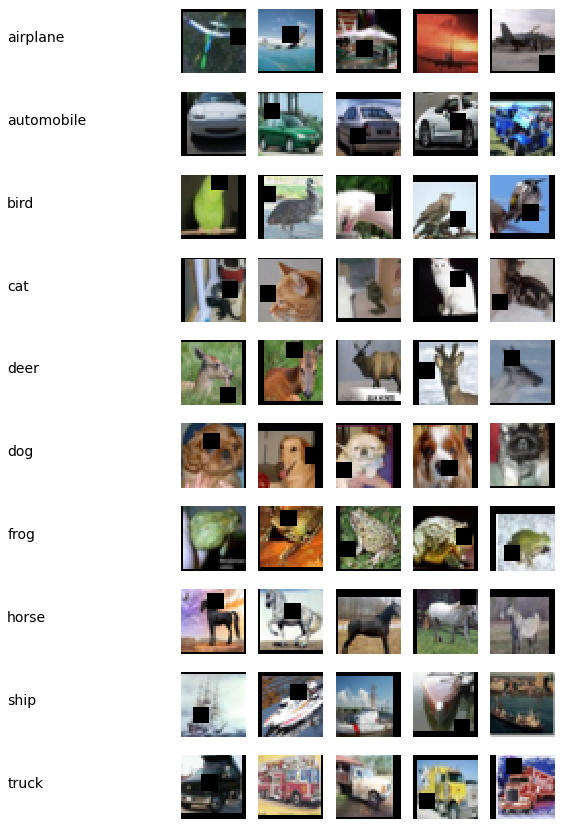

In [ ]:
from __future__ import print_function
# channel_means = (0.49196659, 0.48229005, 0.4461573)
# channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
def unnormalize(img):
  img = img.numpy().astype(dtype=np.float32)
  
  for i in range(img.shape[0]):
    img[i] = (img[i]*sdev[i])+mean[i]
  
  return np.transpose(img, (1,2,0))

%matplotlib inline
import matplotlib.pyplot as plt
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

num_classes = 10
# display 10 images from each category. 
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
r, c = 10, 11
n = 5
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
for i in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==i)[0], n)
    ax = plt.subplot(r, c, i*c+1)
    ax.text(-1.5, 0.5, class_names[i], fontsize=14)
    plt.axis('off')
    for j in range(1, n+1):
      plt.subplot(r, c, i*c+j+1)
      plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
      plt.axis('off')
plt.show()

In [ ]:
class GBN(torch.nn.Module):
    """
    Ghost Batch Normalization
    """

    def __init__(self, input_dim, virtual_batch_size=128, momentum=0.01):
        super(GBN, self).__init__()

        self.input_dim = input_dim
        self.virtual_batch_size = virtual_batch_size
        self.bn = nn.BatchNorm2d(self.input_dim, momentum=momentum)

    def forward(self, x):
        chunks = x.chunk(int(np.ceil(x.shape[0] / self.virtual_batch_size)), 0)
        res = [self.bn(x_) for x_ in chunks]

        return torch.cat(res, dim=0)

In [ ]:
# re-write
conv3x3 = partial(nn.Conv2d, bias=False)
# bn = nn.BatchNorm2d
bn_momentum = 0.3

class CustomResNet(nn.Module): 
    def __init__(self):
        super().__init__()
        self.prep = nn.Sequential(
            conv3x3(3, 64, 3, padding=1), 
            bn(64,momentum=bn_momentum,),
            # GBN(64, virtual_batch_size=16, momentum=bn_momentum),
            nn.ReLU(True)
            )

        self.layer1 = nn.Sequential(
            conv3x3(64, 128, 3, padding=1), 
            nn.MaxPool2d(2, 2),
            bn(128,momentum=bn_momentum),
            # GBN(128, virtual_batch_size=16, momentum=bn_momentum),
            nn.ReLU(True)
            )

        self.res1 = nn.Sequential(
            conv3x3(128, 128, 3, padding=1), 
            bn(128,momentum=bn_momentum),
            # GBN(128, virtual_batch_size=16, momentum=bn_momentum),
            nn.ReLU(True),
            conv3x3(128, 128, 3, padding=1), 
            bn(128,momentum=bn_momentum),
            # GBN(128, virtual_batch_size=16, momentum=bn_momentum),
            nn.ReLU(True)
        )

        self.layer2 =  nn.Sequential(
            conv3x3(128, 256,3, padding=1), 
            nn.MaxPool2d(2, 2),
            bn(256,momentum=bn_momentum),
            # GBN(256, virtual_batch_size=16, momentum=bn_momentum),
            nn.ReLU(True)
        )

        self.layer3 = nn.Sequential(
            conv3x3(256, 512, 3, padding=1), 
            nn.MaxPool2d(2, 2),
            bn(512,momentum=bn_momentum),
            # GBN(512, virtual_batch_size=16, momentum=bn_momentum),
            nn.ReLU(True)
        )

        self.res3 = nn.Sequential(
            conv3x3(512, 512, 3, padding=1), 
            bn(512,momentum=bn_momentum),
            # GBN(512, virtual_batch_size=16, momentum=bn_momentum),
            nn.ReLU(True),
            conv3x3(512, 512, 3, padding=1),
            bn(512,momentum=bn_momentum),
            # GBN(512, virtual_batch_size=16, momentum=bn_momentum),
            nn.ReLU(True)
        )

        self.final_max = nn.MaxPool2d(4)
        self.fc = nn.Linear(in_features = 512, out_features = 10, bias=False)

    def forward(self, x):

        prep = self.prep(x)

        layer1 = self.layer1(prep)
        res1 = self.res1(layer1)
        layer1 = layer1 + res1

        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        res3 = self.res3(layer3)
        layer3 = layer3 + res3

        max = self.final_max(layer3)
        out = max.view(max.size(0),-1)

        fc = self.fc(out)
        
        # out = F.log_softmax(fc.view(-1,10), dim=-1)
        # out  = fc.view(-1,10)
        return out * 0.175 # credit goes to David Page, I am just trying it out, need to figure out how he figured out `0.125` value and effects with BN and image aug

In [ ]:
model = CustomResNet().to(device)

# criterion = LabelSmoothingLoss(classes=10, smoothing=0.12)
# criterion = nn.CrossEntropyLoss()
criterion = LabelSmoothingCrossEntropy(smoothing=0.2)

summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
# criterion = nn.CrossEntropyLoss()

model = CustomResNet().to(device)

# pct: 0.18 -> 0.2 -> 0.24
# lr -> 0.032 -> 0.038 -> 0.04

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr = 0.37, total_steps=None,
                                          pct_start=0.2, anneal_strategy='linear',
                                          epochs=24, steps_per_epoch=len(train_loader),
                                          div_factor=10.0,final_div_factor=1, cycle_momentum=False)#, max_momentum=0.9)

LR = []
lr_epochs = []
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []
reduced_count = 0

# train method only applies RICAP if epoch < 15 and ricap_apply flag is set to True
ricap_apply_prob = -1
ricap=False

for epoch in range(24):
    LR.append(optimizer.param_groups[0]['lr'])
    
    if ricap_apply_prob > np.random.random() and epoch < 10:
        ricap = True
        print(f"\nApplying RICAP at epoch: {epoch+1}")
    else:
        ricap = False
    
    train(model, device, train_loader, optimizer,scheduler,criterion, train_accuracy,
          train_losses, epoch+1,
          ricap_apply=ricap, ricap_beta=0.27,
          end_cycle_lr_epoch=21 ,end_lr_factor=0.45, to_reduce_times=3)
    
    test(model, device, test_loader,test_accuracy, test_losses)



  0%|          | 0/98 [00:00<?, ?it/s]


Epoch num: 1  |  LR: 0.0370000000


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00376, Accuracy: 5126/10000 (51.260%)


Epoch num: 2  |  LR: 0.1065227951


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00219, Accuracy: 7074/10000 (70.740%)


Epoch num: 3  |  LR: 0.1760455901


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00203, Accuracy: 7501/10000 (75.010%)


Epoch num: 4  |  LR: 0.2455683852


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00195, Accuracy: 7554/10000 (75.540%)


Epoch num: 5  |  LR: 0.3150911802


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00194, Accuracy: 7622/10000 (76.220%)


Epoch num: 6  |  LR: 0.3663542730


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00168, Accuracy: 8071/10000 (80.710%)


Epoch num: 7  |  LR: 0.3490105230


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00174, Accuracy: 8110/10000 (81.100%)


Epoch num: 8  |  LR: 0.3316667730


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00156, Accuracy: 8278/10000 (82.780%)


Epoch num: 9  |  LR: 0.3143230230


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00159, Accuracy: 8306/10000 (83.060%)


Epoch num: 10  |  LR: 0.2969792730


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00169, Accuracy: 8367/10000 (83.670%)


Epoch num: 11  |  LR: 0.2796355230


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00136, Accuracy: 8603/10000 (86.030%)


Epoch num: 12  |  LR: 0.2622917730


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00145, Accuracy: 8494/10000 (84.940%)


Epoch num: 13  |  LR: 0.2449480230


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00149, Accuracy: 8367/10000 (83.670%)


Epoch num: 14  |  LR: 0.2276042730


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00148, Accuracy: 8587/10000 (85.870%)


Epoch num: 15  |  LR: 0.2102605230


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00120, Accuracy: 8835/10000 (88.350%)


Epoch num: 16  |  LR: 0.1929167730


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00134, Accuracy: 8814/10000 (88.140%)


Epoch num: 17  |  LR: 0.1755730230


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00122, Accuracy: 8834/10000 (88.340%)


Epoch num: 18  |  LR: 0.1582292730


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00112, Accuracy: 8910/10000 (89.100%)


Epoch num: 19  |  LR: 0.1408855230


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00114, Accuracy: 9013/10000 (90.130%)


Epoch num: 20  |  LR: 0.1235417730


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00119, Accuracy: 8904/10000 (89.040%)

ending lr reduced: 1 times

Epoch num: 21  |  LR: 0.0477891103


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00102, Accuracy: 9185/10000 (91.850%)

ending lr reduced: 2 times

Epoch num: 22  |  LR: 0.0215050996


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00092, Accuracy: 9247/10000 (92.470%)

ending lr reduced: 3 times

Epoch num: 23  |  LR: 0.0096772948


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00092, Accuracy: 9281/10000 (92.810%)


Epoch num: 24  |  LR: 0.0096772948


Loss=1.8357547521591187 Accuracy=97.24: 100%|██████████| 98/98 [00:14<00:00,  6.70it/s]



Test set: Average loss: 0.00093, Accuracy: 9294/10000 (92.940%)



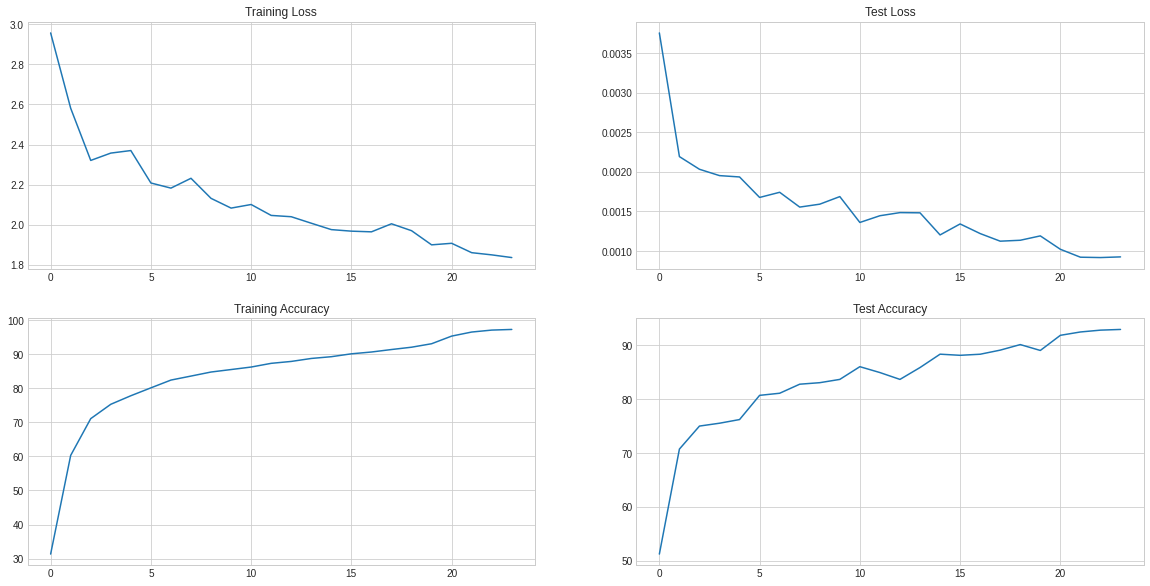

In [ ]:
plot_graphs(train_losses=train_losses, train_accuracy=train_accuracy,
            test_losses=test_losses,test_accuracy=test_accuracy)   

No handles with labels found to put in legend.


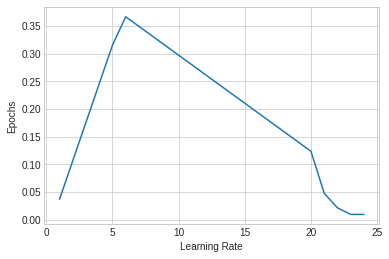

In [ ]:
x, y = [x for x, y in lr_epochs], [y for x, y in lr_epochs]
plt.style.use('seaborn-whitegrid')
plt.plot(x, y)
plt.ylabel('Epochs')
plt.xlabel('Learning Rate')
plt.legend()
plt.show()

In [ ]:
# torch.cuda.empty_cache()
# """to try:
# 1. Ricap
# 2. ZCA whitening -> Need to understand this in detail 
# """